<a href="https://colab.research.google.com/github/leomaurodesenv/kaggle/blob/main/jupyter/identity-document-image-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identity Document Classification

Identity documents play a crucial role in our lives, providing a means to verify our identity and access many services. However, with the increasing number of identity theft cases and illegal activities, it is essential to implement robust systems for identity document classification. This process involves automatically categorizing different types of ID documents, such as passports, driver's licenses, and national identification cards, to ensure security and efficiency in identity verification processes.

> **Summary** - Image classification for ID document detection.   
> Content for intermediate level in Machine Learning and Data Science!


## Use Case

Currently, our customers request or send us various types of documents. From these documents, we extract several important information for them. For this information to be correctly extracted, an automatic document type classification process is necessary. The challenge is to classify at least the RG (Brazilian regional identification) and CPF (Brazilian national identification) documents, using their images, through machine learning.

---
# Dataset

[ricardobnjunior/Brazilian-Identity-Document-Dataset](https://github.com/ricardobnjunior/Brazilian-Identity-Document-Dataset) (BID - Brazilian Identity Document) dataset is a collection of identity images aiming at three crucial challenges in the Computer Vision field: (i) Document Images Classification; (ii) Text Region Segmentation and (iii) Optical Character Recognition (OCR). BID is composed of images of Brazilian identification documents divided into eight classes: front and back faces of driver's license (CNH), CNH front face, CNH back face, Brazilian national identity (CPF) front face, CPF back face, Brazilian regional identity (RG) front face, RG back face, and RG front and back faces.
Counting 28,800 document images, with 3,600 samples for each class.

For simplificy, we will use a subset of the dataset (~ 70MB), not the full dataset (~ 8GB).

In [ ]:
%%capture
!pip install gdown

In [ ]:
# full dataset
# !gdown 1Oi88TRcpdjZmJ79WDLb9qFlBNG8q2De6

In [ ]:
# sample dataset
!gdown 144EqqmMtCziua9iYo-3afUEvZrJVxUXU

Downloading...
From: https://drive.google.com/uc?id=144EqqmMtCziua9iYo-3afUEvZrJVxUXU
To: /content/BID Sample Dataset.zip
100% 71.1M/71.1M [00:00<00:00, 86.4MB/s]


In [ ]:
%%capture
# extracting the dataset
PATH = "/content/BID Sample Dataset"
!unzip "{PATH}.zip"

## Cleaning the Dataset

In this dataset we have eight types of identity. I selected three types for this use case: `CNH_Frente`, `CPF_Frente` e `RG_Frente`.

In [ ]:
# removing unused classes
!rm -r "{PATH}/CNH_Aberta"
!rm -r "{PATH}/CNH_Verso"
!rm -r "{PATH}/CPF_Verso"
!rm -r "{PATH}/RG_Aberto"
!rm -r "{PATH}/RG_Verso"

In [ ]:
# removing unused files, for OCR and Segmentation
!find "{PATH}/CNH_Frente/" -maxdepth 1 -type f -name "*_ocr.txt" -delete
!find "{PATH}/CNH_Frente/" -maxdepth 1 -type f -name "*_segmentation.jpg" -delete
!ls "{PATH}/CNH_Frente/"

00003604_in.jpg  00003613_in.jpg  00003622_in.jpg  00003631_in.jpg
00003605_in.jpg  00003614_in.jpg  00003623_in.jpg  00003632_in.jpg
00003606_in.jpg  00003615_in.jpg  00003624_in.jpg  00003633_in.jpg
00003607_in.jpg  00003616_in.jpg  00003625_in.jpg  00003634_in.jpg
00003608_in.jpg  00003617_in.jpg  00003626_in.jpg  00003635_in.jpg
00003609_in.jpg  00003618_in.jpg  00003627_in.jpg  00003636_in.jpg
00003610_in.jpg  00003619_in.jpg  00003628_in.jpg  00003637_in.jpg
00003611_in.jpg  00003620_in.jpg  00003629_in.jpg  00003638_in.jpg
00003612_in.jpg  00003621_in.jpg  00003630_in.jpg  00003639_in.jpg


In [ ]:
# removing unused files, for OCR and Segmentation
!find "{PATH}/CPF_Frente/" -maxdepth 1 -type f -name "*_ocr.txt" -delete
!find "{PATH}/CPF_Frente/" -maxdepth 1 -type f -name "*_segmentation.jpg" -delete
!find "{PATH}/RG_Frente/" -maxdepth 1 -type f -name "*_ocr.txt" -delete
!find "{PATH}/RG_Frente/" -maxdepth 1 -type f -name "*_segmentation.jpg" -delete

See an image sample.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


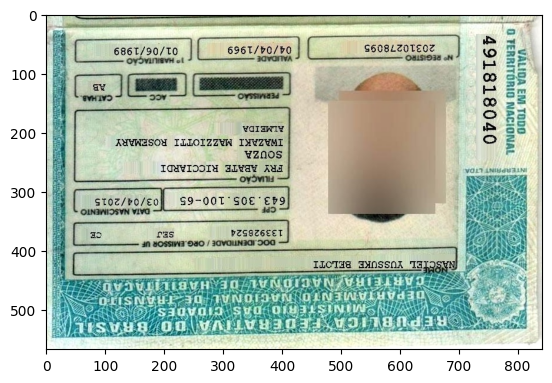

In [ ]:
%pylab inline
img = mpimg.imread(f'{PATH}/CNH_Frente/00003607_in.jpg')
imgplot = plt.imshow(img)
plt.show()

## Building the Dataset

Let's build the training and validation sets using `Keras`.

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib
data_dir = pathlib.Path(PATH)
data_dir

PosixPath('/content/BID Sample Dataset')

In [ ]:
# setup
seed = 123
crop = False
batch_size = 32
img_height = 400
img_width = 400
validation_split = 0.2

# train set
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=validation_split, subset="training", seed=seed,
    image_size=(img_height, img_width), batch_size=batch_size, crop_to_aspect_ratio=crop,
)

# validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=validation_split, subset="validation", seed=seed,
    image_size=(img_height, img_width), batch_size=batch_size, crop_to_aspect_ratio=crop,
)

Found 108 files belonging to 3 classes.
Using 87 files for training.
Found 108 files belonging to 3 classes.
Using 21 files for validation.


In [ ]:
# nome das classes
class_names = train_ds.class_names
class_names

['CNH_Frente', 'CPF_Frente', 'RG_Frente']

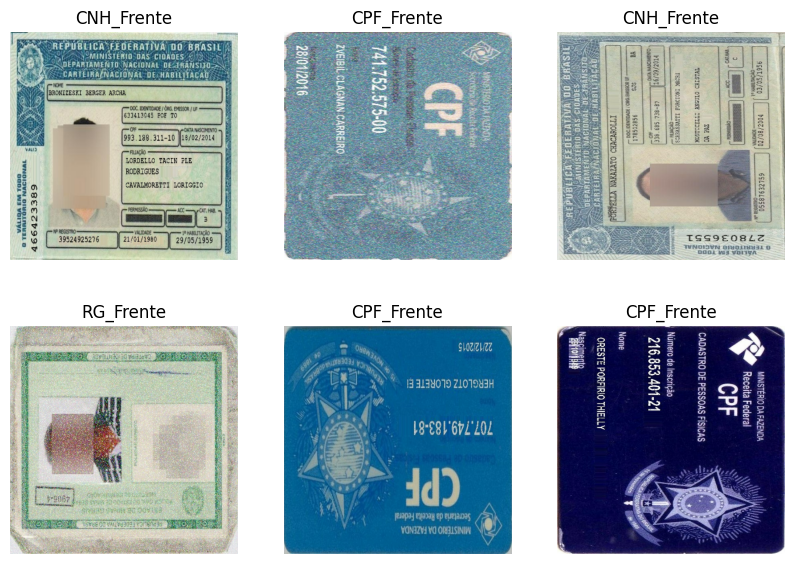

In [ ]:
# showing the train set
plt.figure(figsize=(10, 7))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

---
# Machine Learning

In this section we will configure the preprocessing steps and the image classification model. Preprocessing consists of Image Augmentation and Standardization. While, the model will be a Convolutional Neural Network + Feedforward with Dropout.

In [ ]:
# buffer for faster load
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(seed).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

To avoid overfitting, as we have a small dataset, and to increase the amount of data in the dataset; Let's conduct Augmentation on the data. We will use three types of augmentation, they are: image rotation, flipping and zoom adjustment.

>  Note: data augmentation is disabled at test/validation time, so input images will only be upscaled during calls to `Model.fit` on the training set.

In [ ]:
# data normalization
# -- resizing for a fixed size
# -- value rescaling between [0, 1]
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(img_height, img_width),
  layers.Rescaling(1./255)
])

In [ ]:
# data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.05),
])

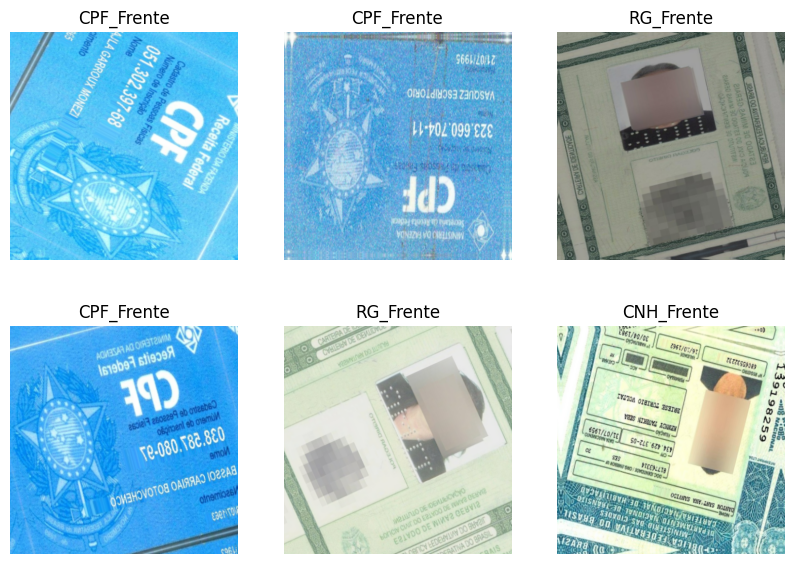

In [ ]:
# visualizing the augmented data
plt.figure(figsize=(10, 7))
for images, labels in train_ds.take(1):
  for i in range(6):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Modeling

Our neural network is composed of (i) preprocessing layers (data normalization and augmentation); (ii) convolutional layers; and (iii) Feedforward for model classification. Let us add a Dropout layer at the end of the convolutional layer to avoid overfitting in the classification network.

> Note: given that this model features data augmentation and dropout layers, its convergence is expected to be slower (i.e., more training epochs are required). However, this model will be more adaptive to real data and avoid overfitting.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  # preprocessing
  data_augmentation,
  resize_and_rescale,
  # convolutional layers
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # feed foward layers
  layers.Flatten(),
  layers.Dropout(0.3),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
# early stopping, to avoid overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

In [ ]:
%%time
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[early_stopping]
)

Epoch 1/200
3/3 [==============================] - 5s 314ms/step - loss: 1.2226 - accuracy: 0.4253 - val_loss: 1.3940 - val_accuracy: 0.4286
Epoch 2/200
3/3 [==============================] - 1s 183ms/step - loss: 0.7894 - accuracy: 0.6207 - val_loss: 0.5003 - val_accuracy: 0.9048
Epoch 3/200
3/3 [==============================] - 0s 159ms/step - loss: 0.6728 - accuracy: 0.6437 - val_loss: 0.5040 - val_accuracy: 0.5238
Epoch 4/200
3/3 [==============================] - 1s 186ms/step - loss: 0.4602 - accuracy: 0.7701 - val_loss: 0.4779 - val_accuracy: 0.5238
Epoch 5/200
3/3 [==============================] - 1s 184ms/step - loss: 0.5120 - accuracy: 0.7586 - val_loss: 0.2976 - val_accuracy: 0.9048
Epoch 6/200
3/3 [==============================] - 1s 207ms/step - loss: 0.4960 - accuracy: 0.7356 - val_loss: 0.2904 - val_accuracy: 0.9048
Epoch 7/200
3/3 [==============================] - 1s 182ms/step - loss: 0.3902 - accuracy: 0.8621 - val_loss: 0.2867 - val_accuracy: 0.9048
Epoch 8/200
3

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 400, 400, 3)       0         
                                                                 
 sequential (Sequential)     (None, 400, 400, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 400, 400, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 200, 200, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 200, 200, 32)      18464     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 100, 100, 32)      0         
 g2D)                                                 

## Model Performance

We were able to build a model with high accuracy and low overfitting bias.

> Note: we noticed that the training accuracy is noisy. This occurs due to the data augmentation and dropout layers. However, we were able to see an increasing improvement in the evaluation of the validation set.


<Axes: title={'center': 'Accuracy'}>

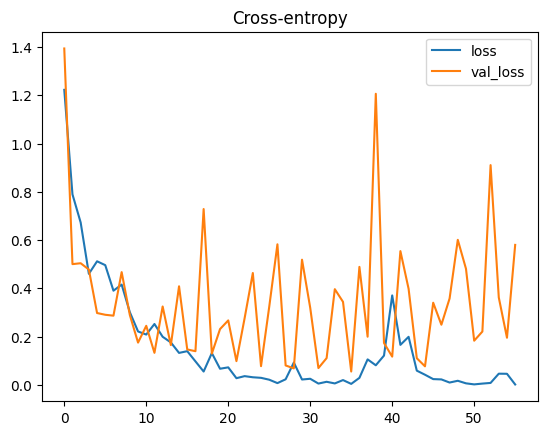

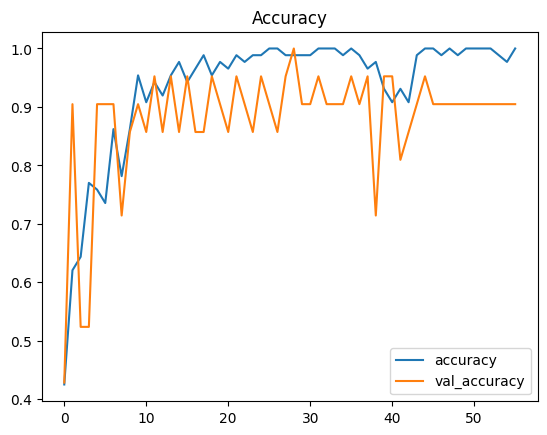

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

## Saving the Model

See how to save and load the model.

In [ ]:
PATH_MODEL = '/content/model_checkpoint'
model.save(
    PATH_MODEL,
    overwrite=True, include_optimizer=True, save_traces=True
)

In [ ]:
# tamanho do modelo
!du -h "{PATH_MODEL}"
!echo ""
# ziping the modelo
!zip -r model.zip "{PATH_MODEL}"

4.0K	/content/model_checkpoint/assets
118M	/content/model_checkpoint/variables
119M	/content/model_checkpoint

  adding: content/model_checkpoint/ (stored 0%)
  adding: content/model_checkpoint/assets/ (stored 0%)
  adding: content/model_checkpoint/keras_metadata.pb (deflated 93%)
  adding: content/model_checkpoint/variables/ (stored 0%)
  adding: content/model_checkpoint/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: content/model_checkpoint/variables/variables.index (deflated 65%)
  adding: content/model_checkpoint/fingerprint.pb (stored 0%)
  adding: content/model_checkpoint/saved_model.pb (deflated 88%)


### Loading the Model

In [ ]:
from tensorflow.keras.models import load_model

model2 = load_model('/content/model_checkpoint')
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 400, 400, 3)       0         
                                                                 
 sequential (Sequential)     (None, 400, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 400, 400, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 200, 200, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 100, 100, 32)      0         
 g2D)                                                 